In [4]:
import torch 
import torch.nn as nn

In [260]:
class ACNet(nn.Module):
    def __init__(self,q,dt):
        self.lay = 200
        super(ACNet,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, self.lay),
            nn.Tanh(),
            nn.Linear( self.lay, self.lay),
            nn.Tanh(),
            nn.Linear( self.lay, self.lay),
            nn.Tanh(),
            nn.Linear( self.lay, self.lay),
            nn.Tanh(),
            nn.Linear( self.lay,q+1)
        )
        tmp = np.float32(np.loadtxt('Utilities/IRK_weights/Butcher_IRK%d.txt' % (q), ndmin = 2))
        self.IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q))
        self.IRK_times = tmp[q**2+q:]
        self.dt = dt

    def forward(self, x):
        x = self.net(x)
        return x

    # loss function
    def MSE(self,ypred,ytrue):
        return torch.sum((ypred - ytrue)**2) 

    # Glorot initialization of weight matrix
    def glorot_init_mat(self,shape):
        din = shape[0]
        dout = shape[1]
        var = torch.tensor([2.0/(din+dout)])
        std = torch.sqrt(var)
        mean = torch.tensor([0.0])
        dist = torch.distributions.normal.Normal(mean, std)
        return dist.sample(shape)
    
    def U_ic(self, x0):
        xc = x0.clone()
        xc.requires_grad = True
        U = self.forward(xc)
        Uc = U[:,:-1]
        Ucx = torch.autograd.grad(Uc.sum(), xc,  create_graph=True)[0]
        Ucxx = torch.autograd.grad(Ucx.sum(),xc,  create_graph=True)[0]
        F = -0.0001*Ucxx + 5*Uc**3 - 5*Uc
        u0_pred = U + torch.Tensor(self.dt)*F.mm(torch.tensor(self.IRK_weights).t())
        return u0_pred
    
    def U_bc(self, xb):
        xbc = xb.clone()
        xbc.requires_grad = True
        Ub_pred = self.forward(xbc)
        Ub_pred1 = torch.autograd.grad(Ub_pred.sum(),xbc,create_graph=True)[0]
        return Ub_pred, Ub_pred1

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from pyDOE import lhs
import argparse
import scipy.io

In [262]:
parser = argparse.ArgumentParser()
parser.add_argument("--epochs", help="Number of epochs to train neural network for")
parser.add_argument("--lr", help="learning rate")
"""data prep"""
"""
DE: u_t-0.0001*u_{xx}+5*u^3-5*u=0
"""
args = parser.parse_args(['--epochs','200000','--lr','0.001'])

In [263]:
data = scipy.io.loadmat('Data/AC.mat')
    
t = data['tt'].flatten()[:,None]#T x 1
x = data['x'].flatten()[:,None]# N x 1
Exact = np.real(data['uu'])#N x T

In [264]:
N, q = 200,100
# Doman bounds
lb = np.array([-1.0])
ub = np.array([1.0])

idx_t0 = 20
idx_t1 = 180
dt = t[idx_t1] - t[idx_t0]
# Generate samples for x, t
#sample points
#noise_u0 = 0.0
idx_x = np.random.choice(Exact.shape[0], N, replace=False) 
x0 = x[idx_x,:]
u0 = Exact[idx_x, idx_t0:idx_t0+1]
#u0 = u0 + noise_u0*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])

# Boudanry data
xb = np.vstack((lb,ub))
x_star = x
x_star = torch.tensor(x_star).type(torch.FloatTensor)
u_star = Exact[:, idx_t1:idx_t1+1]

In [265]:

"""NN class, init, loss functions, dataloader"""

# %%
"""training process"""
#Instantiate class
pn = ACNet(q,dt)
# %%
#load u0
u0 = u0.reshape((-1, 1))
u0 = torch.tensor(u0).type(torch.FloatTensor)
# load x, t data into torch
x0 = x0.reshape((-1, 1))
x0 = torch.tensor(x0).type(torch.FloatTensor)

xb = xb.reshape((-1, 1))
xb = torch.tensor(xb).type(torch.FloatTensor)

In [266]:
# %%

#Initialize weights
#Glorot initialization
[W, b] = list(pn.net[0].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.net[2].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.net[4].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.net[6].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.net[8].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

bb=0

In [267]:
# %%
# Perform backprop
MAX_EPOCHS = int(args.epochs)
#LRATE = 3e-4
LRATE = float(args.lr)

#Use Adam for training
optimizer = torch.optim.Adam(pn.parameters(), lr=LRATE)

loss_history_ic = []
loss_history_bc = []
loss_history = []

In [268]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 2 every 15000 epochs"""
    lr = float(args.lr) * (0.5 ** (epoch // 20000))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [269]:
import time
start_time = time.time()
for epoch in range(MAX_EPOCHS):
    adjust_learning_rate(optimizer,epoch)
    #full batch

    #initial condition
    u0_pred = pn.U_ic(x0)
    mse_ic = pn.MSE(u0_pred, u0.expand(u0_pred.shape))
    loss_history_ic.append([epoch, mse_ic.item()])
    
    #boundary condition
    Ub_pred, Ub_pred1 = pn.U_bc(xb)
    mse_bc = pn.MSE(Ub_pred[0:1,:], Ub_pred[1:2,:])+ pn.MSE(Ub_pred1[0:1,:], Ub_pred1[1:2,:])
    loss_history_bc.append([epoch, mse_bc.item()])

    loss = mse_ic + mse_bc
    loss_history.append([epoch, loss.item()])

    #optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0:
        print("Epoch: {}, MSE_ic: {:.4f}, MSE_bc: {:.4f},, MSE: {:.4f}".format((epoch+1), mse_ic, mse_bc, loss))
elapsed = time.time() - start_time

Epoch: 1000, MSE_ic: 1328.8104, MSE_bc: 183.3814,, MSE: 1512.1918
Epoch: 2000, MSE_ic: 1027.6824, MSE_bc: 542.0565,, MSE: 1569.7389
Epoch: 3000, MSE_ic: 250.5032, MSE_bc: 0.5250,, MSE: 251.0282
Epoch: 4000, MSE_ic: 162.4285, MSE_bc: 0.1133,, MSE: 162.5418
Epoch: 5000, MSE_ic: 105.4611, MSE_bc: 0.4532,, MSE: 105.9143
Epoch: 6000, MSE_ic: 45.3633, MSE_bc: 0.1162,, MSE: 45.4795
Epoch: 7000, MSE_ic: 24.2447, MSE_bc: 0.0283,, MSE: 24.2730
Epoch: 8000, MSE_ic: 30.5195, MSE_bc: 6.1652,, MSE: 36.6847
Epoch: 9000, MSE_ic: 8.1038, MSE_bc: 0.4584,, MSE: 8.5623
Epoch: 10000, MSE_ic: 1934.4432, MSE_bc: 56.3623,, MSE: 1990.8055
Epoch: 11000, MSE_ic: 100.3051, MSE_bc: 0.1301,, MSE: 100.4351
Epoch: 12000, MSE_ic: 51.6292, MSE_bc: 0.0466,, MSE: 51.6758
Epoch: 13000, MSE_ic: 30.1703, MSE_bc: 0.0813,, MSE: 30.2516
Epoch: 14000, MSE_ic: 16.3543, MSE_bc: 0.0504,, MSE: 16.4046
Epoch: 15000, MSE_ic: 8.4802, MSE_bc: 0.0254,, MSE: 8.5056
Epoch: 16000, MSE_ic: 4.1009, MSE_bc: 0.0671,, MSE: 4.1680
Epoch: 17000, 

Epoch: 139000, MSE_ic: 0.0075, MSE_bc: 0.0138,, MSE: 0.0213
Epoch: 140000, MSE_ic: 0.0048, MSE_bc: 0.0029,, MSE: 0.0077
Epoch: 141000, MSE_ic: 0.0047, MSE_bc: 0.0028,, MSE: 0.0075
Epoch: 142000, MSE_ic: 0.0047, MSE_bc: 0.0028,, MSE: 0.0075
Epoch: 143000, MSE_ic: 0.0046, MSE_bc: 0.0029,, MSE: 0.0075
Epoch: 144000, MSE_ic: 0.0046, MSE_bc: 0.0028,, MSE: 0.0074
Epoch: 145000, MSE_ic: 0.0046, MSE_bc: 0.0028,, MSE: 0.0073
Epoch: 146000, MSE_ic: 0.0057, MSE_bc: 0.0026,, MSE: 0.0083
Epoch: 147000, MSE_ic: 0.0045, MSE_bc: 0.0027,, MSE: 0.0073
Epoch: 148000, MSE_ic: 0.0045, MSE_bc: 0.0028,, MSE: 0.0072
Epoch: 149000, MSE_ic: 0.0045, MSE_bc: 0.0032,, MSE: 0.0078
Epoch: 150000, MSE_ic: 0.0049, MSE_bc: 0.0059,, MSE: 0.0108
Epoch: 151000, MSE_ic: 0.0044, MSE_bc: 0.0028,, MSE: 0.0072
Epoch: 152000, MSE_ic: 0.0043, MSE_bc: 0.0027,, MSE: 0.0070
Epoch: 153000, MSE_ic: 0.0044, MSE_bc: 0.0028,, MSE: 0.0072
Epoch: 154000, MSE_ic: 0.0043, MSE_bc: 0.0027,, MSE: 0.0070
Epoch: 155000, MSE_ic: 0.0042, MSE_bc: 0

In [270]:
elapsed

5873.001950979233

In [271]:
#%%
#save trained model
fname = "ACNet_{}.pt".format(MAX_EPOCHS)
torch.save(pn, fname)

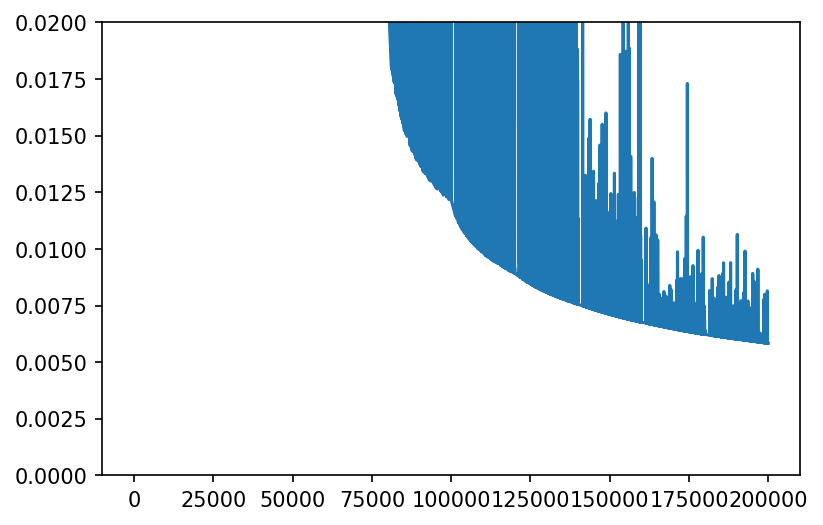

In [279]:
#%%
loss_history = np.array(loss_history)
plt.figure(dpi=150)
plt.plot(loss_history[:,0], loss_history[:,1])
plt.ylim((0, 0.02))
plt.savefig("ACNet_loss_hist_{}-5.png".format(MAX_EPOCHS))
#plt.show()

In [280]:
U1_pred = pn.forward(x_star)
u1_pred = U1_pred[:,-1]
error = np.linalg.norm(u1_pred.detach().numpy() - u_star.reshape(512), 2)/np.linalg.norm(u_star.reshape(512), 2)
print('Error: %e' % (error))

Error: 3.142674e-01


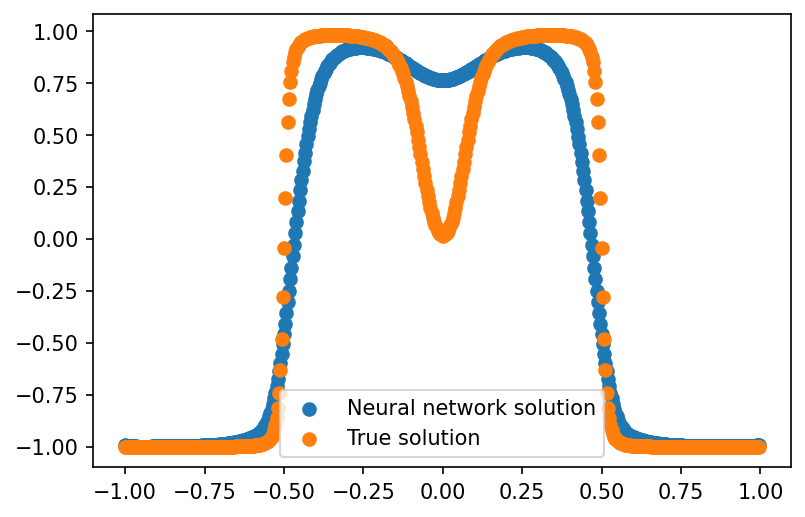

In [282]:
#%%
plt.figure(dpi=150)
plt.scatter(x_star.data.numpy(), u1_pred.data.numpy(), label="Neural network solution")
plt.scatter(x_star.data.numpy(), u_star, label="True solution")
plt.legend()
plt.savefig("PINN_soln_comp_{}.png".format(MAX_EPOCHS))
#plt.show()

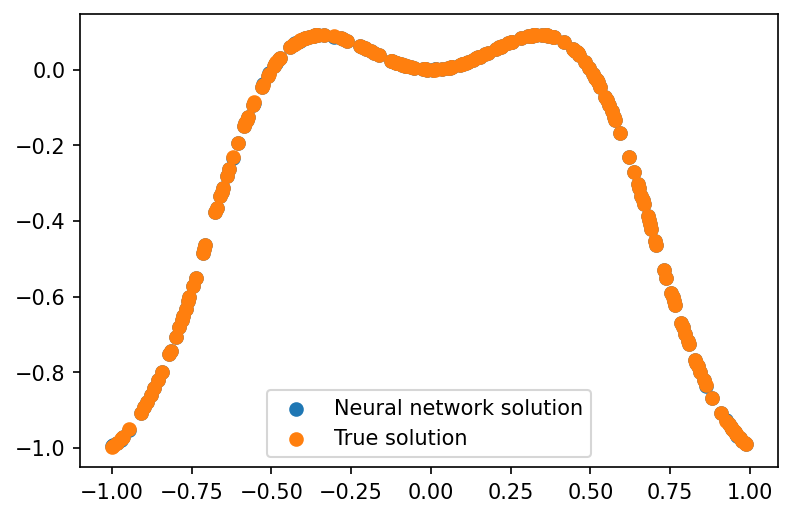

In [283]:
#%%
plt.figure(dpi=150)

plt.scatter(x0.data.numpy(), u0_pred[:,0:1].data.numpy(), label="Neural network solution")
plt.scatter(x0.data.numpy(), u0, label="True solution")
plt.legend()
#plt.savefig("PINN_soln_comp_{}.png".format(N_f))
#plt.show()